In [2]:
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb
from catboost import CatBoostClassifier
import glob
import os

C:\Users\DELL\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pd.set_option("display.max_columns", 100)
%matplotlib inline

In [4]:
RANDOM_SEED = 6

In [14]:
DATA_PATH = Path.cwd() / ""
train_df = pd.read_csv(DATA_PATH / "train.csv", index_col="tripid")
train_df['checkout_datetime'] = pd.to_datetime(train_df['drop_time'])
train_df['checkin_datetime'] = pd.to_datetime(train_df['pickup_time'])
#train_df['duration'] = train_df['checkout_datetime']-train_df['checkin_datetime']
train_df['duration_in_minutes'] = (train_df['checkout_datetime']-train_df['checkin_datetime'])/pd.Timedelta(minutes=1)
train_df['lat']  = abs(train_df['pick_lat']-train_df['drop_lat'])
train_df['lon']  = abs(train_df['pick_lon']-train_df['drop_lon'])
#train_df['distance'] = ((train_df['lat'])**2 + (train_df['lon'])**2)**(1/2)
#train_df['manhatton_distance'] = (train_df['lat']**2 - train_df['lon']**2)




#train_df['meter_waiting_fare'] = train_df['meter_waiting_fare'].astype(np.int64)


#train_df['is_waiting_fare'] = train_df['meter_waiting']*train_df['meter_waiting_fare']
#train_df['additional_fare'] = train_df['meter_waiting_till_pickup']*train_df['additional_fare']

train_df['date_time'] = pd.to_datetime(train_df['drop_time'])
#train_df['drop_Hour'] = train_df['date_time'].apply(lambda x: x.hour+1)

#train_df['weekday'] = train_df['date_time'].apply(lambda x: x.weekday())
train_df['remaining_fare'] = train_df['fare']-train_df['additional_fare']-train_df['meter_waiting_fare']
train_df['r_fare'] = train_df['fare']-train_df['meter_waiting_fare']
train_df['mobile_time'] = train_df['duration']-train_df['meter_waiting']-train_df['meter_waiting_till_pickup']
train_df['m_time'] = train_df['duration']-train_df['meter_waiting_till_pickup']
#train_df['unknown'] = train_df['meter_waiting']+train_df['meter_waiting_till_pickup']
#train_df['mobile_fare_time'] = train_df['remaining_fare']-train_df['mobile_time']
train_df['fare'] = train_df['fare'].fillna(0)
#train_df['meter_waiting'] = train_df['meter_waiting_till_pickup'].fillna(0)


#q = train_df["fare"].quantile(0.999)
#print(q)

#train_df.loc[(train_df['fare'] <= q), 'fare'] = 0
#train_df.loc[(train_df['fare'] > q), 'fare'] = 1
#train_df.loc[(train_df['meter_waiting'] > 10000) , 'high_time'] = 1
#train_df.loc[(train_df['meter_waiting'] <=10000) , 'high_time'] = 0 


#train_df
#train_df['pick_Hour'] = pd.to_datetime(train_df['pickup_time'])
#train_df['pick_Hour'] = train_df['pick_Hour'].apply(lambda x: x.hour+1)

#features_df_num = train_df.drop(["date_time","pickup_time","drop_time","duration","checkin_datetime","drop_lat","drop_lon","checkout_datetime", "label"], axis = 1)
features_df = train_df.drop(["date_time","duration",'pick_lat','pick_lon','drop_lat','drop_lon',"pickup_time","drop_time","checkin_datetime","checkout_datetime", "label"], axis = 1)

pure_train_df = train_df.drop(["label"], axis = 1)
categorical_features = pure_train_df.columns[pure_train_df.dtypes == "object"].values


label_df = train_df[["label"]]
label_df = label_df.replace({'label': {'correct': 1, 'incorrect': 0}})

features_df

additional_fare  duration  meter_waiting  meter_waiting_fare  \
tripid                                                                    
189123628             10.5     834.0           56.0            0.000000   
189125358             10.5     791.0           47.0            0.000000   
189125719             10.5    1087.0           80.0            0.000000   
189127273             10.5     598.0          271.0           15.663800   
189128020              NaN       NaN            NaN                 NaN   
189129552             10.5    3407.0          182.0            0.000000   
189132829             10.5    1246.0          487.0            0.000000   
189135103             10.5    1333.0          295.0           17.198500   
189139296             10.5     360.0           80.0            4.664000   
189138671             10.5    1539.0          588.0           33.986400   
189135814             10.5      26.0           19.0            0.000000   
189140969             10.5      31.0           20.0            0.000000   
189144528             10.5    2011.0          199.0            0.000000   
189147041             10.5    1260.0           30.0            0.000000   
189145904             10.5     335.0           10.0            0.583000   
189146174             10.5    4221.0         1608.0           84.214600   
189150541             10.5    1472.0          219.0           12.699976   
189153229             10.5     284.0            0.0            0.000000   
189151585             10.5    2435.0          381.0            0.000000   
189157464             10.5     891.0          170.0            0.000000   
189157607             10.5    2956.0         1686.0           97.450800   
189157476             10.5    3176.0          390.0            0.000000   
189157559             10.5     693.0          280.0            9.883800   
189159951              5.0     850.0          143.0            8.336900   
189158726             10.5    1443.0           59.0            0.000000   
189160756             10.5     358.0           66.0            0.000000   
189161377             10.5     644.0          638.0           14.796800   
189163162             10.5     618.0          128.0            7.398400   
189164454             10.5    1407.0          210.0            0.000000   
189164880             10.5     575.0           23.0            0.000000   
189164806             10.5    3549.0         2689.0          146.985400   
189164831              NaN       NaN            NaN                 NaN   
189165701              5.0    1588.0          302.0           17.606600   
189165828             10.5    2523.0          140.0            8.108414   
189164791             10.5     286.0           44.0            0.000000   
189165178             10.5     537.0           30.0            1.734000   
189165865             10.5     345.0           10.0            0.000000   
189166546             10.5    1892.0           50.0            0.000000   
189168392             10.5    1952.0          484.0           25.894400   
189168508             10.5     558.0           77.0            0.115600   
189170751             10.5    2847.0          865.0            0.000000   
189170729             10.5     323.0           90.0            4.103800   
189172042             10.5     433.0           58.0            0.000000   
189172150             10.5     188.0           10.0            0.000000   
189174640             10.5    1409.0          100.0            4.392800   
189176766             10.5    7008.0         6120.0          345.181600   
189177024             10.5     495.0          298.0           12.080200   
189177562             10.5    1466.0            0.0            0.000000   
189178968             10.5    1939.0          338.0           19.536400   
189178922             10.5    1326.0          199.0           11.601700   
189179135             10.5     799.0          210.0           12.138000   
189182800             10.5     220.0

In [5]:
features_list = features_df.columns.tolist()
features_list

['additional_fare',
 'meter_waiting',
 'meter_waiting_fare',
 'meter_waiting_till_pickup',
 'fare',
 'duration_in_minutes',
 'lat',
 'lon',
 'remaining_fare',
 'r_fare',
 'mobile_time',
 'm_time']

In [6]:
## chain numerical preprocessing into a pipeline object
numeric_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('minmax_scaler', MinMaxScaler()),    
])

## chain non-numerical preprocessing into a pipeline object
non_numeric_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore')),
#     ('label_encoder', LabelEncoder())
])

## create preprocessor stage of the final pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_preprocessing_steps, features_list)
    ],
    remainder = 'drop'
)



In [7]:
#estimator =  RandomForestClassifier( class_weight='balanced', n_estimators=500, criterion="entropy")
#estimator =  RandomForestClassifier( class_weight='balanced', n_estimators=400)
#estimator = GradientBoostingClassifier(loss='exponential',n_estimators=50000)
#estimator = KNeighborsClassifier(n_neighbors=100, weights="uniform", algorithm="brute")
#param={'lambda':0.1}
estimator = XGBClassifier()
#estimator = CatBoostClassifier()

#estimator = lgb.LGBMClassifier(learning_rate=0.1)
#estimator =  RandomForestClassifier( class_weight='balanced', n_estimators=400, max_depth=200, max_features=10)

In [8]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimator)
])


In [9]:
features_df

additional_fare  meter_waiting  meter_waiting_fare  \
tripid                                                          
189123628             10.5           56.0              0.0000   
189125358             10.5           47.0              0.0000   
189125719             10.5           80.0              0.0000   
189127273             10.5          271.0             15.6638   
189128020              NaN            NaN                 NaN   
...                    ...            ...                 ...   
213803193             10.5           93.0              5.4219   
213812756             10.5          428.0              0.0000   
213813930             10.5            9.0              0.0000   
213815405             10.5          115.0              0.0000   
213817296             10.5           21.0              1.2243   

           meter_waiting_till_pickup    fare  duration_in_minutes      lat  \
tripid                                                                       
189123628                       64.0  270.32                 14.0  0.04078   
189125358                      134.0  197.85                 13.0  0.02784   
189125719                       61.0  301.64                 18.0  0.02830   
189127273                       68.0   82.30                 10.0  0.00178   
189128020                        NaN  358.39                 17.0  0.02963   
...                              ...     ...                  ...      ...   
213803193                      451.0  198.26                 14.0  0.00182   
213812756                       39.0  581.23                 36.0  0.04520   
213813930                      110.0   76.20                  4.0  0.00925   
213815405                      317.0  133.31                 14.0  0.00966   
213817296                       23.0   98.57                  4.0  0.00566   

              lon  remaining_fare    r_fare  mobile_time  m_time  
tripid                                                            
189123628  0.0210        259.8200  270.3200        714.0   770.0  
189125358  0.0061        187.3500  197.8500        610.0   657.0  
189125719  0.0495        291.1400  301.6400        946.0  1026.0  
189127273  0.0076         56.1362   66.6362        259.0   530.0  
189128020  0.0675             NaN       NaN          NaN     NaN  
...           ...             ...       ...          ...     ...  
213803193  0.0190        182.3381  192.8381        294.0   387.0  
213812756  0.0873        570.7300  581.2300       1684.0  2112.0  
213813930  0.0017         65.7000   76.2000        144.0   153.0  
213815405  0.0242        122.8100  133.3100        426.0   541.0  
213817296  0.0183         86.8457   97.3457        218.0   239.0  

[17176 rows x 12 columns]

In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(features_df, label_df, test_size=0.3, shuffle=True, stratify=label_df, random_state=RANDOM_SEED)

## Train the model
pipeline.fit(X_train, y_train)

# Predict for the evaluation set

print("Training Accuracy: %.2f" % (pipeline.score(X_eval, y_eval)*100), "%")
preds = pipeline.predict_proba(X_eval)


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 95.38 %


In [29]:
l = preds[:,1].tolist()
for i in range(len(l)):
    if l[i]<0.5:
        l[i]=0
    else:
        l[i]=1
true_y = y_eval['label'].tolist()
f1_score(true_y, l)


0.9745000529044544

In [30]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(estimator)
fig = pyplot.figure(figsize=(20,20))
fig.show()

ValueError: tree must be Booster, XGBModel or dict instance

Feature: 0, Score: 4.47045
Feature: 1, Score: 4.93678
Feature: 2, Score: 3.46679
Feature: 3, Score: 5.47028
Feature: 4, Score: 15.74890
Feature: 5, Score: 7.10740
Feature: 6, Score: 8.93732
Feature: 7, Score: 7.57851
Feature: 8, Score: 9.55468
Feature: 9, Score: 12.23285
Feature: 10, Score: 15.82900
Feature: 11, Score: 4.66704


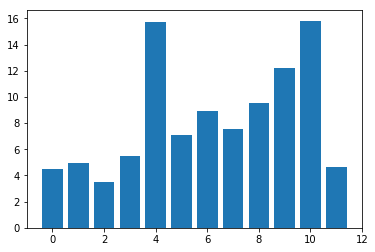

In [31]:
importance = estimator.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [32]:
pipeline.fit(features_df, label_df)

None


Learning rate set to 0.034693
0:	learn: 0.6522258	total: 67.9ms	remaining: 1m 7s
1:	learn: 0.6145462	total: 140ms	remaining: 1m 9s
2:	learn: 0.5791402	total: 185ms	remaining: 1m 1s
3:	learn: 0.5478853	total: 260ms	remaining: 1m 4s
4:	learn: 0.5190565	total: 329ms	remaining: 1m 5s
5:	learn: 0.4926967	total: 370ms	remaining: 1m 1s
6:	learn: 0.4707415	total: 409ms	remaining: 58s
7:	learn: 0.4494940	total: 459ms	remaining: 56.9s
8:	learn: 0.4310531	total: 533ms	remaining: 58.7s
9:	learn: 0.4123897	total: 579ms	remaining: 57.4s
10:	learn: 0.3950530	total: 627ms	remaining: 56.3s
11:	learn: 0.3798005	total: 664ms	remaining: 54.7s
12:	learn: 0.3677244	total: 699ms	remaining: 53.1s
13:	learn: 0.3567723	total: 735ms	remaining: 51.8s
14:	learn: 0.3458840	total: 783ms	remaining: 51.4s
15:	learn: 0.3340890	total: 830ms	remaining: 51.1s
16:	learn: 0.3239299	total: 870ms	remaining: 50.3s
17:	learn: 0.3142254	total: 923ms	remaining: 50.4s
18:	learn: 0.3056823	total: 960ms	remaining: 49.6s
19:	learn: 0

167:	learn: 0.1493053	total: 5.21s	remaining: 25.8s
168:	learn: 0.1490478	total: 5.24s	remaining: 25.8s
169:	learn: 0.1489035	total: 5.25s	remaining: 25.6s
170:	learn: 0.1486707	total: 5.27s	remaining: 25.6s
171:	learn: 0.1485717	total: 5.29s	remaining: 25.5s
172:	learn: 0.1484692	total: 5.31s	remaining: 25.4s
173:	learn: 0.1481528	total: 5.33s	remaining: 25.3s
174:	learn: 0.1479745	total: 5.35s	remaining: 25.2s
175:	learn: 0.1477472	total: 5.37s	remaining: 25.1s
176:	learn: 0.1475925	total: 5.39s	remaining: 25s
177:	learn: 0.1473698	total: 5.4s	remaining: 24.9s
178:	learn: 0.1470890	total: 5.42s	remaining: 24.9s
179:	learn: 0.1469330	total: 5.44s	remaining: 24.8s
180:	learn: 0.1466908	total: 5.46s	remaining: 24.7s
181:	learn: 0.1464719	total: 5.48s	remaining: 24.6s
182:	learn: 0.1463602	total: 5.5s	remaining: 24.5s
183:	learn: 0.1462032	total: 5.52s	remaining: 24.5s
184:	learn: 0.1461162	total: 5.54s	remaining: 24.4s
185:	learn: 0.1458869	total: 5.57s	remaining: 24.4s
186:	learn: 0.14

335:	learn: 0.1262562	total: 7.81s	remaining: 15.4s
336:	learn: 0.1261480	total: 7.83s	remaining: 15.4s
337:	learn: 0.1260312	total: 7.84s	remaining: 15.4s
338:	learn: 0.1258735	total: 7.85s	remaining: 15.3s
339:	learn: 0.1257891	total: 7.87s	remaining: 15.3s
340:	learn: 0.1257274	total: 7.88s	remaining: 15.2s
341:	learn: 0.1256832	total: 7.89s	remaining: 15.2s
342:	learn: 0.1256196	total: 7.9s	remaining: 15.1s
343:	learn: 0.1255078	total: 7.92s	remaining: 15.1s
344:	learn: 0.1254021	total: 7.93s	remaining: 15.1s
345:	learn: 0.1253030	total: 7.94s	remaining: 15s
346:	learn: 0.1251569	total: 7.96s	remaining: 15s
347:	learn: 0.1250924	total: 7.97s	remaining: 14.9s
348:	learn: 0.1249843	total: 7.98s	remaining: 14.9s
349:	learn: 0.1248847	total: 8s	remaining: 14.9s
350:	learn: 0.1247824	total: 8.02s	remaining: 14.8s
351:	learn: 0.1246728	total: 8.03s	remaining: 14.8s
352:	learn: 0.1245902	total: 8.04s	remaining: 14.7s
353:	learn: 0.1245312	total: 8.05s	remaining: 14.7s
354:	learn: 0.124398

503:	learn: 0.1123031	total: 10.1s	remaining: 9.96s
504:	learn: 0.1122484	total: 10.1s	remaining: 9.94s
505:	learn: 0.1121555	total: 10.2s	remaining: 9.91s
506:	learn: 0.1120775	total: 10.2s	remaining: 9.88s
507:	learn: 0.1119731	total: 10.2s	remaining: 9.86s
508:	learn: 0.1119478	total: 10.2s	remaining: 9.83s
509:	learn: 0.1118774	total: 10.2s	remaining: 9.8s
510:	learn: 0.1117729	total: 10.2s	remaining: 9.77s
511:	learn: 0.1116816	total: 10.2s	remaining: 9.75s
512:	learn: 0.1115612	total: 10.2s	remaining: 9.72s
513:	learn: 0.1115157	total: 10.3s	remaining: 9.69s
514:	learn: 0.1114475	total: 10.3s	remaining: 9.67s
515:	learn: 0.1113188	total: 10.3s	remaining: 9.64s
516:	learn: 0.1112498	total: 10.3s	remaining: 9.61s
517:	learn: 0.1111361	total: 10.3s	remaining: 9.59s
518:	learn: 0.1109556	total: 10.3s	remaining: 9.56s
519:	learn: 0.1109136	total: 10.3s	remaining: 9.54s
520:	learn: 0.1108711	total: 10.4s	remaining: 9.52s
521:	learn: 0.1108099	total: 10.4s	remaining: 9.49s
522:	learn: 0

668:	learn: 0.1019062	total: 12.4s	remaining: 6.13s
669:	learn: 0.1018662	total: 12.4s	remaining: 6.11s
670:	learn: 0.1018112	total: 12.4s	remaining: 6.08s
671:	learn: 0.1017837	total: 12.4s	remaining: 6.06s
672:	learn: 0.1016854	total: 12.4s	remaining: 6.04s
673:	learn: 0.1016212	total: 12.5s	remaining: 6.02s
674:	learn: 0.1015612	total: 12.5s	remaining: 6s
675:	learn: 0.1015134	total: 12.5s	remaining: 5.98s
676:	learn: 0.1014425	total: 12.5s	remaining: 5.96s
677:	learn: 0.1014172	total: 12.5s	remaining: 5.94s
678:	learn: 0.1013969	total: 12.5s	remaining: 5.92s
679:	learn: 0.1013813	total: 12.5s	remaining: 5.9s
680:	learn: 0.1013712	total: 12.5s	remaining: 5.88s
681:	learn: 0.1013220	total: 12.6s	remaining: 5.85s
682:	learn: 0.1012852	total: 12.6s	remaining: 5.83s
683:	learn: 0.1012244	total: 12.6s	remaining: 5.81s
684:	learn: 0.1011711	total: 12.6s	remaining: 5.79s
685:	learn: 0.1010899	total: 12.6s	remaining: 5.77s
686:	learn: 0.1009950	total: 12.6s	remaining: 5.75s
687:	learn: 0.10

831:	learn: 0.0937455	total: 14.6s	remaining: 2.96s
832:	learn: 0.0936471	total: 14.7s	remaining: 2.94s
833:	learn: 0.0935603	total: 14.7s	remaining: 2.92s
834:	learn: 0.0935384	total: 14.7s	remaining: 2.9s
835:	learn: 0.0935042	total: 14.7s	remaining: 2.88s
836:	learn: 0.0933964	total: 14.7s	remaining: 2.87s
837:	learn: 0.0933308	total: 14.7s	remaining: 2.85s
838:	learn: 0.0932892	total: 14.7s	remaining: 2.83s
839:	learn: 0.0932460	total: 14.8s	remaining: 2.81s
840:	learn: 0.0931582	total: 14.8s	remaining: 2.79s
841:	learn: 0.0931017	total: 14.8s	remaining: 2.77s
842:	learn: 0.0930765	total: 14.8s	remaining: 2.75s
843:	learn: 0.0930397	total: 14.8s	remaining: 2.73s
844:	learn: 0.0929930	total: 14.8s	remaining: 2.72s
845:	learn: 0.0929448	total: 14.8s	remaining: 2.7s
846:	learn: 0.0929050	total: 14.8s	remaining: 2.68s
847:	learn: 0.0928683	total: 14.9s	remaining: 2.66s
848:	learn: 0.0928547	total: 14.9s	remaining: 2.65s
849:	learn: 0.0928226	total: 14.9s	remaining: 2.63s
850:	learn: 0.

994:	learn: 0.0869426	total: 16.9s	remaining: 84.9ms
995:	learn: 0.0869387	total: 16.9s	remaining: 67.9ms
996:	learn: 0.0869048	total: 16.9s	remaining: 50.9ms
997:	learn: 0.0868556	total: 16.9s	remaining: 33.9ms
998:	learn: 0.0867992	total: 16.9s	remaining: 17ms
999:	learn: 0.0867395	total: 17s	remaining: 0us


In [33]:
test_set = pd.read_csv(DATA_PATH / "test.csv", index_col="tripid")
test_set.head()


additional_fare  duration  meter_waiting  meter_waiting_fare  \
tripid                                                                    
213284604             10.5       924             42              2.4486   
213286352             10.5      4249             20              0.0000   
213293973             10.5      1552            255              2.6588   
213294622             10.5       462             16              0.0000   
213298687             10.5       814            392             12.3692   

           meter_waiting_till_pickup    pickup_time      drop_time  pick_lat  \
tripid                                                                         
213284604                        148  2/1/2020 0:38  2/1/2020 0:53   6.83454   
213286352                         91  2/1/2020 1:02  2/1/2020 2:13   6.91168   
213293973                         23  2/1/2020 5:02  2/1/2020 5:28   6.92145   
213294622                        198  2/1/2020 5:30  2/1/2020 5:38   6.77433   
213298687                         69  2/1/2020 7:00  2/1/2020 7:14   6.97968   

           pick_lon  drop_lat  drop_lon     fare  
tripid                                            
213284604   79.8750   6.77490   79.8840   289.27  
213286352   79.8723   6.55091   79.9706  1912.70  
213293973   79.8478   6.90539   79.8989   394.00  
213294622   79.9416   6.80401   79.9407   154.32  
213298687   79.9130   6.98875   79.8914   147.47

In [34]:
test_set['checkout_datetime'] = pd.to_datetime(test_set['drop_time'])
test_set['checkin_datetime'] = pd.to_datetime(test_set['pickup_time'])
#train_df['duration'] = train_df['checkout_datetime']-train_df['checkin_datetime']
test_set['duration_in_minutes'] = (test_set['checkout_datetime']-test_set['checkin_datetime'])/pd.Timedelta(minutes=1)
test_set['lat']  = abs(test_set['pick_lat']-test_set['drop_lat'])
test_set['lon']  = abs(test_set['pick_lon']-test_set['drop_lon'])
#test_set['distance'] = ((test_set['lat'])**2 + (test_set['lon'])**2)**(1/2)

#test_set.loc[test_set['meter_waiting_fare'] > 0, 'is_meter_waiting_fare'] = 1
#test_set.loc[test_set['meter_waiting_fare'] <= 0, 'is_meter_waiting_fare'] = 0
test_set['date_time'] = pd.to_datetime(test_set['drop_time'])
#test_set['drop_Hour'] = test_set['date_time'].apply(lambda x: x.hour+1)
test_set['remaining_fare'] = test_set['fare']-test_set['additional_fare']-test_set['meter_waiting_fare']
test_set['mobile_time'] = test_set['duration']-test_set['meter_waiting']-test_set['meter_waiting_till_pickup']
test_set['r_fare'] = test_set['fare']-test_set['meter_waiting_fare']
test_set['m_time'] = test_set['duration']-test_set['meter_waiting_till_pickup']
#train_df['mobile_fare_time'] = train_df['remaining_fare']-train_df['mobile_time']
#train_df['r_fare'] = train_df['meter_waiting_fare']+train_df['additional_fare']
test_set['fare'] = test_set['fare'].fillna(0)
#test_set['weekday'] = test_set['date_time'].apply(lambda x: x.weekday())



#test_set['distance'] = ((test_set['lat'])**2 + (test_set['lat'])**2)**(1/2)

new_test_set = test_set.drop(["date_time","duration","pickup_time","drop_time","pick_lat","pick_lon","checkin_datetime","drop_lat","drop_lon","checkout_datetime"], axis = 1)

#new_test_set = test_set.drop(["date_time","pickup_time", "drop_time","duration","meter_waiting_fare","drop_lat","drop_lon","checkin_datetime", "checkout_datetime"], axis = 1)
new_test_set

additional_fare  meter_waiting  meter_waiting_fare  \
tripid                                                          
213284604             10.5             42             2.44860   
213286352             10.5             20             0.00000   
213293973             10.5            255             2.65880   
213294622             10.5             16             0.00000   
213298687             10.5            392            12.36920   
...                    ...            ...                 ...   
222856243             10.5            429            24.83332   
222857785             10.5             80             0.00000   
222858416             10.5             56             3.28440   
222858691             10.5            548            31.67440   
222860703             10.5            691            32.88820   

           meter_waiting_till_pickup     fare  duration_in_minutes      lat  \
tripid                                                                        
213284604                        148   289.27                 15.0  0.05964   
213286352                         91  1912.70                 71.0  0.36077   
213293973                         23   394.00                 26.0  0.01606   
213294622                        198   154.32                  8.0  0.02968   
213298687                         69   147.47                 14.0  0.00907   
...                              ...      ...                  ...      ...   
222856243                          3   388.48                 28.0  0.00485   
222857785                        125   379.85                 23.0  0.00819   
222858416                         93   112.79                  7.0  0.01850   
222858691                         17   248.46                 27.0  0.01870   
222860703                         42   339.63                 28.0  0.04662   

              lon  remaining_fare  mobile_time      r_fare  m_time  
tripid                                                              
213284604  0.0090       276.32140          734   286.82140     776  
213286352  0.0983      1902.20000         4138  1912.70000    4158  
213293973  0.0511       380.84120         1274   391.34120    1529  
213294622  0.0009       143.82000          248   154.32000     264  
213298687  0.0216       124.60080          353   135.10080     745  
...           ...             ...          ...         ...     ...  
222856243  0.0353       353.14668         1291   363.64668    1720  
222857785  0.0676       369.35000         1173   379.85000    1253  
222858416  0.0002        99.00560          269   109.50560     325  
222858691  0.0299       206.28560         1039   216.78560    1587  
222860703  0.0148       296.24180          965   306.74180    1656  

[8576 rows x 12 columns]

In [35]:
test_probs = pipeline.predict_proba(new_test_set)


In [36]:
test_probs

array([[0.0163988 , 0.9836012 ],
       [0.53393922, 0.46606078],
       [0.1133664 , 0.8866336 ],
       ...,
       [0.01042651, 0.98957349],
       [0.02081442, 0.97918558],
       [0.03701984, 0.96298016]])

In [37]:
submission_set = pd.read_csv(DATA_PATH / "sample_submission.csv", index_col="tripid")
submission_set.head()


prediction
tripid               
213284604           1
213286352           0
213293973           0
213294622           1
213298687           1

In [38]:
try:
    np.testing.assert_array_equal(test_set.index.values, submission_set.index.values)
    print("rows in the same order")
except:
    print("rows not in the same order or error")


rows in the same order


In [39]:
submission_set['prediction'] = test_probs[:,1]


In [40]:
submission_set

prediction
tripid               
213284604    0.983601
213286352    0.466061
213293973    0.886634
213294622    0.980966
213298687    0.990378
...               ...
222856243    0.939821
222857785    0.988277
222858416    0.989573
222858691    0.979186
222860703    0.962980

[8576 rows x 1 columns]

In [41]:
submission_set.loc[submission_set['prediction'] > 0.5, 'prediction'] = 1
submission_set.loc[submission_set['prediction'] <= 0.5, 'prediction'] = 0
submission_set['prediction'] = submission_set['prediction'].astype(np.int64)


#submission_set['presiction'].convert_dtypes(convert_integer: bool = True)
submission_set



prediction
tripid               
213284604           1
213286352           0
213293973           1
213294622           1
213298687           1
...               ...
222856243           1
222857785           1
222858416           1
222858691           1
222860703           1

[8576 rows x 1 columns]

In [42]:
submission_set.to_csv('160374E_catboost_new_new.csv', index=True)
print("Completed!")


Completed!
